In [108]:
import pandas as pd
import numpy as np
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, GRU, Bidirectional, Conv3D, MaxPooling3D, Flatten, TimeDistributed
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
import scipy
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split

In [2]:
ue_df = pd.read_csv(r'/root/ghazi/PrbUsed/Data/UEReports.csv')
ue_df

,timestamp,Viavi.UE.Name,Viavi.UE.Slice,Viavi.Cell.Name,Viavi.Cell.beam,Viavi.mMIMO.Type,Viavi.mMIMO.Group,Viavi.mMIMO.Beamforming,Viavi.UE.Rsrp,Viavi.UE.Rsrq,...,RRU.PrbUsedUl,TB.TotNbrUl,DRB.UECqiDl,DRB.UEThpDl,RRU.PrbUsedDl,TB.TotNbrDl,Viavi.CA.cells,Viavi.Geo.x,Viavi.Geo.y,Viavi.Geo.z
0,1721001600000,Indoor-1,eMBB,S1/N77/C2,1,SSB,1,Digital,-123.153442,-14.289001,...,0.0,0,0,0.000000,0.0,0,1,-84,-16,2
1,1721001600000,Indoor-2,eMBB,S2/N77/C1,1,SSB,1,Digital,-92.153442,-10.796079,...,0.0,0,0,0.000000,0.0,0,1,925,-14,12
2,1721001600000,UE-3,eMBB,S1/N77/C1,1,SSB,1,Digital,-95.153442,-10.800321,...,0.0,0,0,0.000000,0.0,0,1,39,173,2
3,1721001600000,UE-4,eMBB,S1/N77/C1,1,SSB,1,Digital,-100.153442,-10.818660,...,0.0,0,0,0.000000,0.0,0,1,189,-52,2
4,1721001600000,UE-5,eMBB,S2/N77/C1,1,SSB,1,Digital,-105.153442,-10.876151,...,0.0,0,0,0.000000,0.0,0,1,1039,173,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4147195,1721260799000,UE-12,eMBB,S2/N77/C3,9,SSB,1,Digital,-70.153442,-10.791840,...,46.0,8142,15,0.045778,32.0,70639,1,1160,114,0
4147196,1721260799000,UE-13,eMBB,S2/N77/C3,9,SSB,1,Digital,-64.153442,-10.791820,...,45.0,6846,15,0.045778,32.0,59297,1,1140,149,0
4147197,1721260799000,UE-14,eMBB,S2/N77/C3,9,SSB,1,Digital,-99.153442,-10.813152,...,46.0,7270,13,0.039398,32.0,63156,1,1085,185,1
4147198,1721260799000,UE-15,eMBB,S2/N77/C3,9,SSB,1,Digital,-65.153442,-10.791821,...,45.0,6948,15,0.045778,32.0,61979,1,1145,148,0


In [3]:
ue_data = ue_df.copy()

In [4]:
ue_data = ue_data.drop(columns = ['Viavi.UE.Slice', 'Viavi.mMIMO.Type', 'Viavi.mMIMO.Group', 'Viavi.mMIMO.Beamforming', 'Viavi.UE.anomalies', 'Viavi.QoS.Priority', 'Viavi.QoS.5q', 
                                  'Viavi.CA.cells'])

In [5]:
ue_data['timestamp'] = pd.to_datetime(ue_data['timestamp'], unit='ms')
ue_data

,timestamp,Viavi.UE.Name,Viavi.Cell.Name,Viavi.Cell.beam,Viavi.UE.Rsrp,Viavi.UE.Rsrq,Viavi.UE.RsSinr,Viavi.UE.targetThroughputDl,Viavi.QoS.Score,DRB.UECqiUl,DRB.UEThpUl,RRU.PrbUsedUl,TB.TotNbrUl,DRB.UECqiDl,DRB.UEThpDl,RRU.PrbUsedDl,TB.TotNbrDl,Viavi.Geo.x,Viavi.Geo.y,Viavi.Geo.z
0,2024-07-15 00:00:00,Indoor-1,S1/N77/C2,1,-123.153442,-14.289001,-0.924652,0.001,100,0,0.000000,0.0,0,0,0.000000,0.0,0,-84,-16,2
1,2024-07-15 00:00:00,Indoor-2,S2/N77/C1,1,-92.153442,-10.796079,30.075348,0.001,100,0,0.000000,0.0,0,0,0.000000,0.0,0,925,-14,12
2,2024-07-15 00:00:00,UE-3,S1/N77/C1,1,-95.153442,-10.800321,27.075348,0.010,100,0,0.000000,0.0,0,0,0.000000,0.0,0,39,173,2
3,2024-07-15 00:00:00,UE-4,S1/N77/C1,1,-100.153442,-10.818660,22.075348,0.010,100,0,0.000000,0.0,0,0,0.000000,0.0,0,189,-52,2
4,2024-07-15 00:00:00,UE-5,S2/N77/C1,1,-105.153442,-10.876151,17.075348,0.010,100,0,0.000000,0.0,0,0,0.000000,0.0,0,1039,173,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4147195,2024-07-17 23:59:59,UE-12,S2/N77/C3,9,-70.153442,-10.791840,52.075348,0.050,92,15,0.007322,46.0,8142,15,0.045778,32.0,70639,1160,114,0
4147196,2024-07-17 23:59:59,UE-13,S2/N77/C3,9,-64.153442,-10.791820,58.075348,0.050,92,15,0.007162,45.0,6846,15,0.045778,32.0,59297,1140,149,0
4147197,2024-07-17 23:59:59,UE-14,S2/N77/C3,9,-99.153442,-10.813152,23.075348,0.050,79,13,0.006299,46.0,7270,13,0.039398,32.0,63156,1085,185,1
4147198,2024-07-17 23:59:59,UE-15,S2/N77/C3,9,-65.153442,-10.791821,57.075348,0.050,92,15,0.007162,45.0,6948,15,0.045778,32.0,61979,1145,148,0


In [6]:
s1_c1_data = ue_data[ue_data['Viavi.Cell.Name'].str.contains('S1/N77/C1')]
s1_c1_data

,timestamp,Viavi.UE.Name,Viavi.Cell.Name,Viavi.Cell.beam,Viavi.UE.Rsrp,Viavi.UE.Rsrq,Viavi.UE.RsSinr,Viavi.UE.targetThroughputDl,Viavi.QoS.Score,DRB.UECqiUl,DRB.UEThpUl,RRU.PrbUsedUl,TB.TotNbrUl,DRB.UECqiDl,DRB.UEThpDl,RRU.PrbUsedDl,TB.TotNbrDl,Viavi.Geo.x,Viavi.Geo.y,Viavi.Geo.z
2,2024-07-15 00:00:00,UE-3,S1/N77/C1,1,-95.153442,-10.800321,27.075348,0.010,100,0,0.000000,0.0,0,0,0.000000,0.0,0,39,173,2
3,2024-07-15 00:00:00,UE-4,S1/N77/C1,1,-100.153442,-10.818660,22.075348,0.010,100,0,0.000000,0.0,0,0,0.000000,0.0,0,189,-52,2
6,2024-07-15 00:00:00,UE-7,S1/N77/C1,1,-95.153442,-10.800321,27.075348,0.010,100,0,0.000000,0.0,0,0,0.000000,0.0,0,39,173,2
7,2024-07-15 00:00:00,UE-8,S1/N77/C1,1,-106.153442,-10.897724,16.075348,0.010,100,0,0.000000,0.0,0,0,0.000000,0.0,0,73,164,2
8,2024-07-15 00:00:00,UE-9,S1/N77/C1,1,-100.153442,-10.818660,22.075348,0.010,100,0,0.000000,0.0,0,0,0.000000,0.0,0,1,132,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4147120,2024-07-17 23:59:55,Indoor-1,S1/N77/C1,6,-89.153442,-10.793951,33.075348,0.005,113,15,0.043446,273.0,14310,15,0.005645,4.0,128806,-96,-18,12
4147136,2024-07-17 23:59:56,Indoor-1,S1/N77/C1,6,-89.153442,-10.793951,33.075348,0.005,113,15,0.043446,273.0,14310,15,0.005645,4.0,128806,-96,-18,12
4147152,2024-07-17 23:59:57,Indoor-1,S1/N77/C1,6,-89.153442,-10.793951,33.075348,0.005,113,15,0.043446,273.0,14310,15,0.005645,4.0,128806,-96,-18,12
4147168,2024-07-17 23:59:58,Indoor-1,S1/N77/C1,6,-89.153442,-10.793951,33.075348,0.005,113,15,0.043446,273.0,14310,15,0.005645,4.0,128806,-96,-18,12


In [7]:
s1_c1_data = s1_c1_data.drop(columns = ["Viavi.UE.Name", "Viavi.Cell.Name"])

In [8]:
s1_c1_data

,timestamp,Viavi.Cell.beam,Viavi.UE.Rsrp,Viavi.UE.Rsrq,Viavi.UE.RsSinr,Viavi.UE.targetThroughputDl,Viavi.QoS.Score,DRB.UECqiUl,DRB.UEThpUl,RRU.PrbUsedUl,TB.TotNbrUl,DRB.UECqiDl,DRB.UEThpDl,RRU.PrbUsedDl,TB.TotNbrDl,Viavi.Geo.x,Viavi.Geo.y,Viavi.Geo.z
2,2024-07-15 00:00:00,1,-95.153442,-10.800321,27.075348,0.010,100,0,0.000000,0.0,0,0,0.000000,0.0,0,39,173,2
3,2024-07-15 00:00:00,1,-100.153442,-10.818660,22.075348,0.010,100,0,0.000000,0.0,0,0,0.000000,0.0,0,189,-52,2
6,2024-07-15 00:00:00,1,-95.153442,-10.800321,27.075348,0.010,100,0,0.000000,0.0,0,0,0.000000,0.0,0,39,173,2
7,2024-07-15 00:00:00,1,-106.153442,-10.897724,16.075348,0.010,100,0,0.000000,0.0,0,0,0.000000,0.0,0,73,164,2
8,2024-07-15 00:00:00,1,-100.153442,-10.818660,22.075348,0.010,100,0,0.000000,0.0,0,0,0.000000,0.0,0,1,132,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4147120,2024-07-17 23:59:55,6,-89.153442,-10.793951,33.075348,0.005,113,15,0.043446,273.0,14310,15,0.005645,4.0,128806,-96,-18,12
4147136,2024-07-17 23:59:56,6,-89.153442,-10.793951,33.075348,0.005,113,15,0.043446,273.0,14310,15,0.005645,4.0,128806,-96,-18,12
4147152,2024-07-17 23:59:57,6,-89.153442,-10.793951,33.075348,0.005,113,15,0.043446,273.0,14310,15,0.005645,4.0,128806,-96,-18,12
4147168,2024-07-17 23:59:58,6,-89.153442,-10.793951,33.075348,0.005,113,15,0.043446,273.0,14310,15,0.005645,4.0,128806,-96,-18,12


In [86]:
s1_c1_data = s1_c1_data.groupby(["timestamp", "Viavi.Cell.beam"]).mean()
s1_c1_data
s1_c1_data.to_csv("Data/s1_c1_data.csv", index = False)

In [87]:
data_matter = s1_c1_data[['DRB.UEThpDl', 'Viavi.QoS.Score', 'Viavi.UE.targetThroughputDl', 'RRU.PrbUsedDl']].reset_index()
data_matter['hour'] = data_matter['timestamp'].dt.hour
data_matter['minutes'] = data_matter['timestamp'].dt.minute
data_matter['second'] = data_matter['timestamp'].dt.second
data_matter.to_csv("Data/data_matter.csv", index = False)

In [111]:
data_matter_beam1 = data_matter[data_matter['Viavi.Cell.beam'] == 1].drop(columns = "Viavi.Cell.beam")
data_matter_beam1[(data_matter_beam1['timestamp'] >= '2024-07-17')]['timestamp'].dt.hour.unique()
# data_matter_beam1['timestamp'].dt.hour.unique()

,timestamp,DRB.UEThpDl,Viavi.QoS.Score,Viavi.UE.targetThroughputDl,RRU.PrbUsedDl,hour,minutes,second
205196,2024-07-17 09:00:00,0.000000,100.000000,0.300,0.000000,9,0,0
205197,2024-07-17 09:00:01,0.037703,12.666667,0.300,90.666667,9,0,1
205198,2024-07-17 09:00:02,0.034565,11.666667,0.300,91.000000,9,0,2
205199,2024-07-17 09:00:03,0.167771,56.000000,0.300,124.666667,9,0,3
237596,2024-07-17 18:00:00,0.000000,100.000000,0.164,0.000000,18,0,0
...,...,...,...,...,...,...,...,...
251995,2024-07-17 21:59:59,0.018576,93.000000,0.020,13.000000,21,59,59
251996,2024-07-17 22:00:00,0.000000,100.000000,0.050,0.000000,22,0,0
251997,2024-07-17 22:00:01,0.045202,90.000000,0.050,119.000000,22,0,1
251998,2024-07-17 22:00:02,0.043462,87.000000,0.050,34.000000,22,0,2


In [127]:
def create_sequences(data, target_data, sequence_length=10):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]
        target = target_data[i + sequence_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

def standardize_data(data, isoutput, train_df):
    column_output=['RRU.PrbUsedDl']
    if isoutput:
        mean = train_df[column_output].mean().values
        std = train_df[column_output].std().values
    else:
        mean = train_df.mean().values
        std = train_df.std().values

    # Reshape for broadcasting with 2D matrix
    mean = mean.reshape(1, -1)
    std = std.reshape(1, -1)

    return (data - mean) / std

def inverse_standardize_data(data, isoutput, train_df):
    column_output=['RRU.PrbUsedDl']
    if isoutput:
        mean = train_df[column_output].mean().values
        std = train_df[column_output].std().values
    else:
        mean = train_df.mean().values
        std = train_df.std().values

    # Reshape for broadcasting with 2D matrix
    mean = mean.reshape(1, -1)
    std = std.reshape(1, -1)

    return (data * std) + mean

def plot_result(df_predictions, beam_id):
    df_user = df_predictions
    plt.figure(figsize=(8, 6))
    
    plt.plot(df_user.index, df_user['actual_PrbUsedDl'], label='Actual PrbUsedDl', color='blue')
    plt.plot(df_user.index, df_user['predicted_PrbUsedDl'], label='Predicted PrbUsedDl', color='red')
    
    plt.xlabel('Index')
    plt.ylabel('PrbUsedDl')
    plt.title(f'Actual vs Predicted PrbUsedDl for beam {beam_id}')
    plt.legend()
    plt.grid(True)
    plt.show()

def display_predictions(predictions, actual_values):
    df = pd.DataFrame({
        'predicted_PrbUsedDl': predictions[:, 0],
        'actual_PrbUsedDl': actual_values[:, 0],
    })
    return df

def preprocessing_data(data, beam_id):
    new_data = data[data['Viavi.Cell.beam'] == beam_id]

    train_df, test_time_df = train_test_split(new_data, test_size=0.2, random_state=42, shuffle=False)

    train_df = train_df.drop(columns = ['Viavi.Cell.beam', 'timestamp'])
    test_time_df = test_time_df.drop(columns = ['Viavi.Cell.beam', 'timestamp'])
    
    train_df_scaled = standardize_data(train_df, False, train_df)
    test_df_scaled = standardize_data(test_time_df, False, train_df)
    
    X_train, y_train = create_sequences(train_df_scaled.values, train_df_scaled[['RRU.PrbUsedDl']].values)
    X_test, y_test = create_sequences(test_df_scaled.values, test_df_scaled[['RRU.PrbUsedDl']].values)
    print("X train shape: ", X_train.shape)
    print("y train shape: ", y_train.shape)
    print("X test shape: ", X_test.shape)
    print("y test shape: ", y_test.shape)

    return X_train, y_train, X_test, y_test, train_df

def transfer_learning(data, beam_id):
    X_train, y_train, X_test, y_test, train_df = preprocessing_data(data, beam_id)

    model = load_model("model_transfer.h5")
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mse')

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.fit(X_train, y_train, epochs=10, batch_size = 64, validation_split=0.2, callbacks=[early_stopping])

    predictions = model.predict(X_test)

    predictions_inverse = inverse_standardize_data(predictions, True, train_df)
    y_inverse = inverse_standardize_data(y_test, True, train_df)

    rmse = np.sqrt(mean_squared_error(y_inverse, predictions_inverse))
    print('Test RMSE: ', rmse)

    df_predictions = display_predictions(predictions_inverse, y_inverse)
    print(df_predictions.head())

    plot_result(df_predictions, beam_id)

    return model, rmse

def training(data, beam_id):
    X_train, y_train, X_test, y_test, train_df = preprocessing_data(data, beam_id)

    seq_length = 10
    model = Sequential()
    model.add(LSTM(120, return_sequences=True, input_shape=(seq_length, 7), kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))
    model.add(LSTM(120, return_sequences=True, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))
    model.add(LSTM(100, return_sequences = False,kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation = 'linear'))

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mse')

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train model
    model.fit(X_train, y_train, epochs=10, batch_size = 64, validation_split=0.2, callbacks=[early_stopping])

    predictions = model.predict(X_test)

    predictions_inverse = inverse_standardize_data(predictions, True, train_df)
    y_inverse = inverse_standardize_data(y_test, True, train_df)

    rmse = np.sqrt(mean_squared_error(y_inverse, predictions_inverse))
    print('Test RMSE: ', rmse)

    df_predictions = display_predictions(predictions_inverse, y_inverse)
    print(df_predictions.head())

    return df_predictions, model


In [115]:
df_predictions, first_model = training(data_matter, 1)

X train shape:  (57618, 10, 7)
y train shape:  (57618, 1)
X test shape:  (14398, 10, 7)
y test shape:  (14398, 1)
Epoch 1/10
721/721 [==============================] - 43s 51ms/step - loss: 2.2327 - val_loss: 0.7453
Epoch 2/10
721/721 [==============================] - 35s 49ms/step - loss: 0.6584 - val_loss: 0.2040
Epoch 3/10
721/721 [==============================] - 35s 49ms/step - loss: 0.4039 - val_loss: 0.1051
Epoch 4/10
721/721 [==============================] - 35s 49ms/step - loss: 0.3411 - val_loss: 0.0672
Epoch 5/10
721/721 [==============================] - 35s 49ms/step - loss: 0.3092 - val_loss: 0.0483
Epoch 6/10
721/721 [==============================] - 35s 49ms/step - loss: 0.2964 - val_loss: 0.0395
Epoch 7/10
721/721 [==============================] - 36s 49ms/step - loss: 0.2840 - val_loss: 0.0363
Epoch 8/10
721/721 [==============================] - 35s 49ms/step - loss: 0.2651 - val_loss: 0.0471
Epoch 9/10
721/721 [==============================] - 35s 49ms/step - 

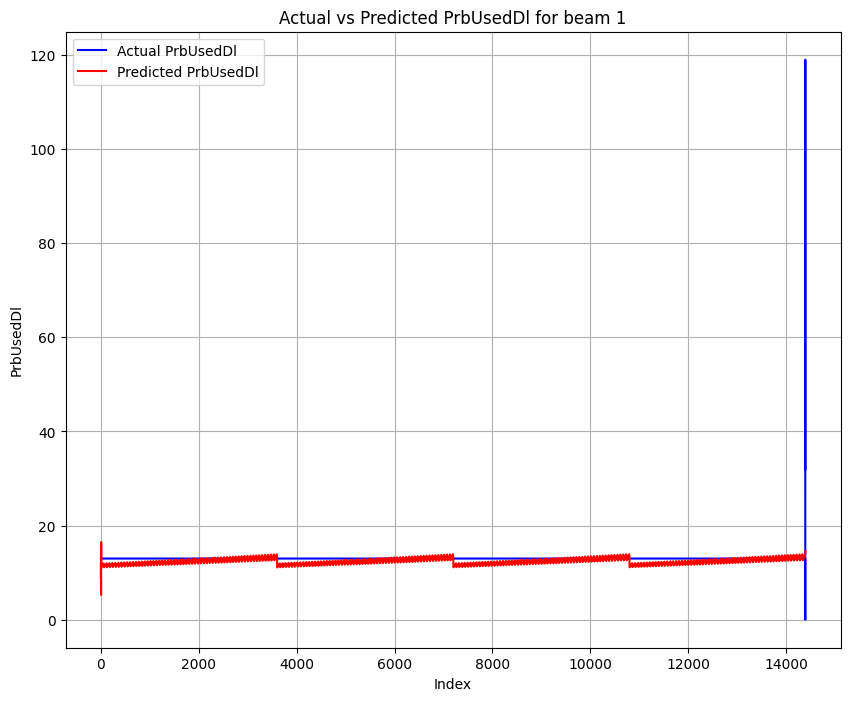

In [116]:
plot_result(df_predictions, 1)

In [117]:
first_model.save("first_beam1.h5")

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [118]:
first_model.save("model_transfer.h5")

In [121]:
beam_list = [6, 9]

Beam id: 6
X train shape:  (43180, 10, 7)
y train shape:  (43180, 1)
X test shape:  (10788, 10, 7)
y test shape:  (10788, 1)
Epoch 1/10
540/540 [==============================] - 33s 52ms/step - loss: 0.0081 - val_loss: 0.0012
Epoch 2/10
540/540 [==============================] - 27s 50ms/step - loss: 0.0078 - val_loss: 0.0011
Epoch 3/10
540/540 [==============================] - 27s 50ms/step - loss: 0.0078 - val_loss: 0.0010
Epoch 4/10
540/540 [==============================] - 27s 50ms/step - loss: 0.0077 - val_loss: 0.0013
Epoch 5/10
540/540 [==============================] - 27s 50ms/step - loss: 0.0077 - val_loss: 9.5970e-04
Epoch 6/10
540/540 [==============================] - 27s 49ms/step - loss: 0.0075 - val_loss: 0.0013
Epoch 7/10
540/540 [==============================] - 27s 49ms/step - loss: 0.0075 - val_loss: 0.0020
Epoch 8/10
540/540 [==============================] - 27s 49ms/step - loss: 0.0076 - val_loss: 0.0011
Epoch 9/10
540/540 [==============================] - 2

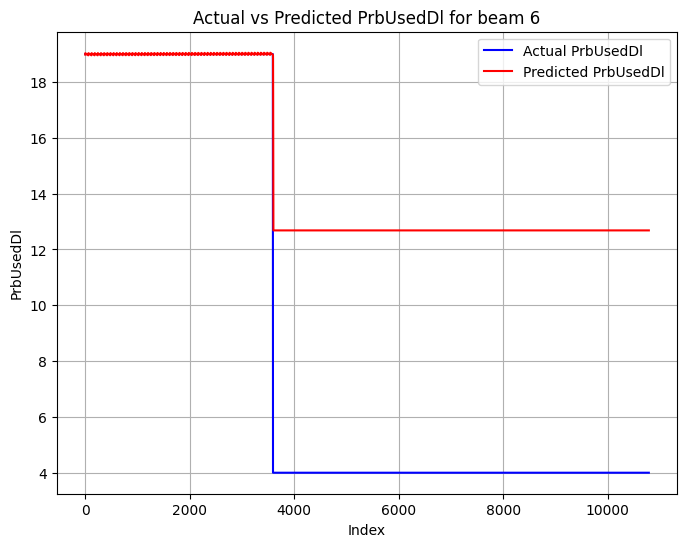



Beam id: 9
X train shape:  (106527, 10, 7)
y train shape:  (106527, 1)
X test shape:  (26625, 10, 7)
y test shape:  (26625, 1)
Epoch 1/10
1332/1332 [==============================] - 75s 51ms/step - loss: 0.0066 - val_loss: 0.0032
Epoch 2/10
1332/1332 [==============================] - 66s 50ms/step - loss: 0.0065 - val_loss: 0.0031
Epoch 3/10
1332/1332 [==============================] - 66s 50ms/step - loss: 0.0065 - val_loss: 0.0031
Epoch 4/10
1332/1332 [==============================] - 66s 49ms/step - loss: 0.0064 - val_loss: 0.0031
Epoch 5/10
1332/1332 [==============================] - 66s 50ms/step - loss: 0.0064 - val_loss: 0.0030
Epoch 6/10
1332/1332 [==============================] - 66s 50ms/step - loss: 0.0064 - val_loss: 0.0046
Epoch 7/10
1332/1332 [==============================] - 66s 50ms/step - loss: 0.0063 - val_loss: 0.0029
Epoch 8/10
1332/1332 [==============================] - 66s 49ms/step - loss: 0.0063 - val_loss: 0.0041
Epoch 9/10
1332/1332 [=================

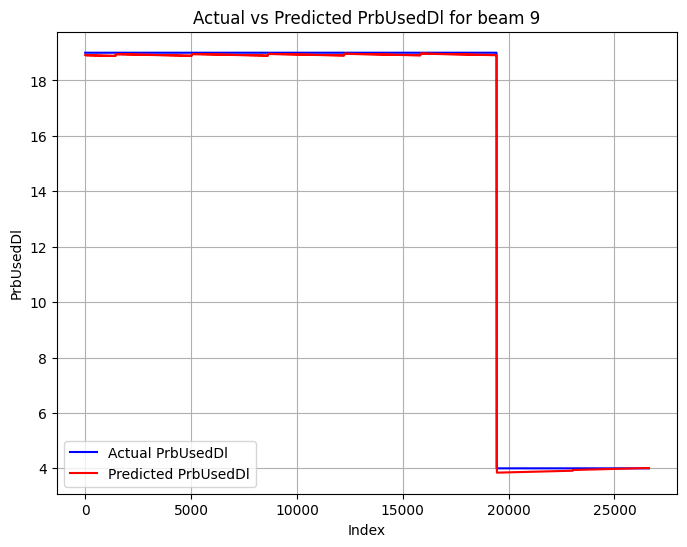

In [128]:
list_rmse = []
for beam in beam_list:
    print(f"Beam id: {beam}")
    model_transfer, rmse = transfer_learning(data_matter, beam)
    list_rmse.append(rmse)
    print()
    print()

In [125]:
model_transfer.save("model_transfer.h5")

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
